# Lab Exercise: Comparison of Self-Attention, Multi-Head Attention, and Feedforward Neural Networks

## Objective:

Understand and compare the function, behavior, and outputs of self-attention, multi-head attention, and feedforward layers in transformer models, using a simple example sentence.

## Part 1: Conceptual Understanding (Pre-Lab)

- Review what each component does:
    - **Self-Attention:** Learn how each word in a sentence attends to (relates to) every other word.
    - **Multi-Head Attention:** See how multiple attention mechanisms operate simultaneously, each capturing different types of relationships.
    - **Feedforward Neural Networks:** Observe how each token embedding is independently processed post-attention for refined transformation.
- Use the sentence:
*"The cat sat on the mat."*
Keep this in mind while running the code and analyzing outputs.


## Part 2: Implement and Visualize Self-Attention

1. **Build a self-attention layer** that calculates attention scores between all words.
2. **Input:** Represent words as vectors (use random or simplified embeddings for demonstration).
3. **Output:** Attention matrix showing how each word attends to others.
4. **Visualize:** Plot the attention weights matrix as a heatmap.

## Part 3: Implement Multi-Head Attention

1. **Build multiple self-attention heads** (e.g., 4 heads), each with different parameters.
2. **Combine their outputs** by concatenation and a projection layer.
3. **Visualize:** Plot each attention head’s matrix separately and the combined output.

## Part 4: Build Feedforward Neural Network Layer

1. Apply a simple feedforward neural network to each word vector after attention.
2. Use at least two dense layers with activation functions (e.g., ReLU).
3. Observe how the vectors transform compared to the attention output.

## Part 5: Analyze and Compare Outputs

1. Compare the attention weights of self-attention vs. multi-head attention.
2. Analyze how feedforward layers refine or transform the attention’s output.
3. Discuss differences in what each component contributes to the model’s understanding.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Sample sentence tokens
tokens = ["The", "cat", "sat", "on", "the", "mat"]
vocab_size = len(tokens)
embedding_dim = 8  # small for demo

# Random embeddings for each word token (normally learned)
torch.manual_seed(0)
embeddings = torch.rand(vocab_size, embedding_dim)

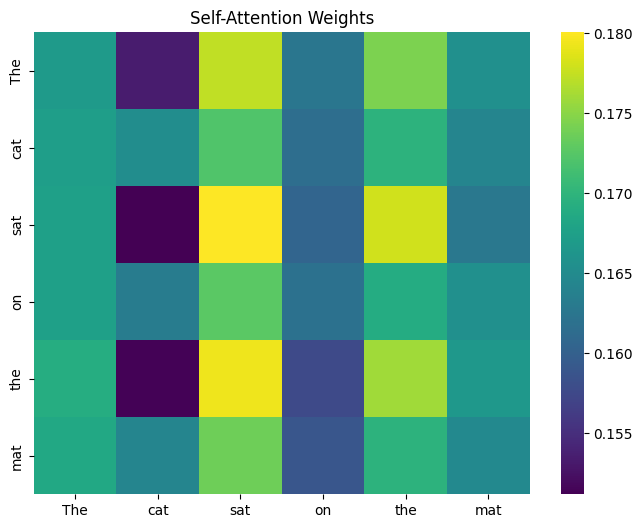

In [2]:
# --------- Part 2: Self-Attention ---------
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)
        return weights, output

self_attention = SelfAttention(embedding_dim)
attn_weights, attn_output = self_attention(embeddings)

# Visualize self-attention weights
plt.figure(figsize=(8,6))
sns.heatmap(attn_weights.detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title("Self-Attention Weights")
plt.show()

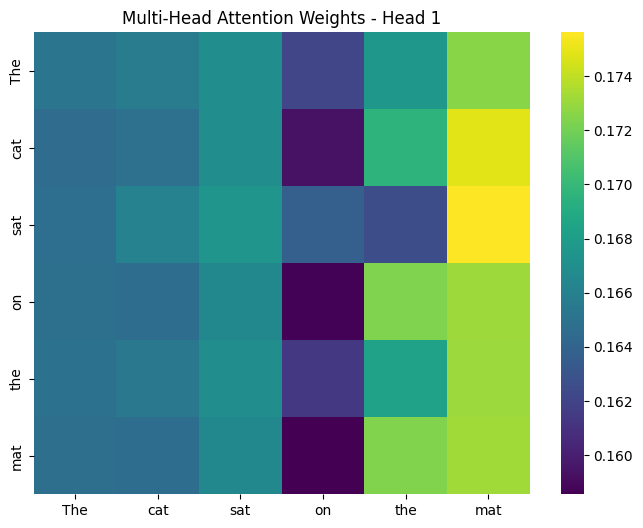

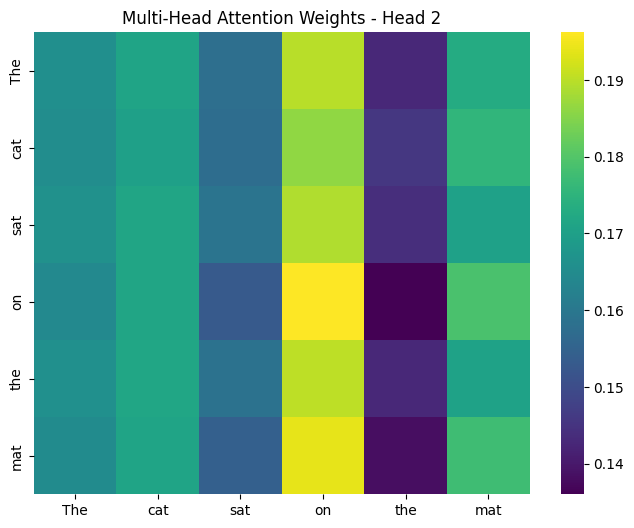

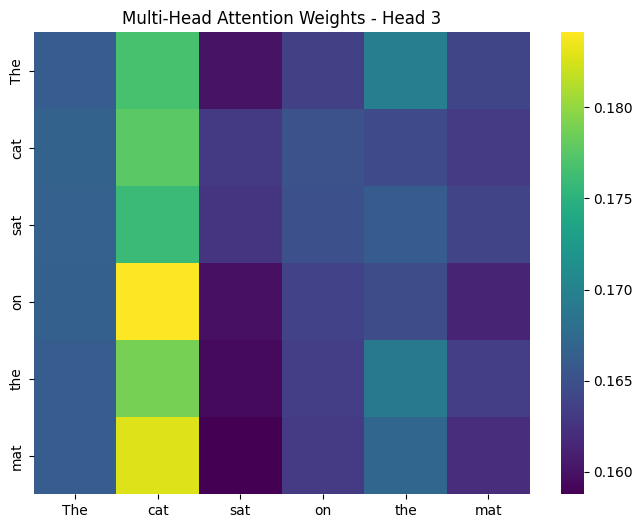

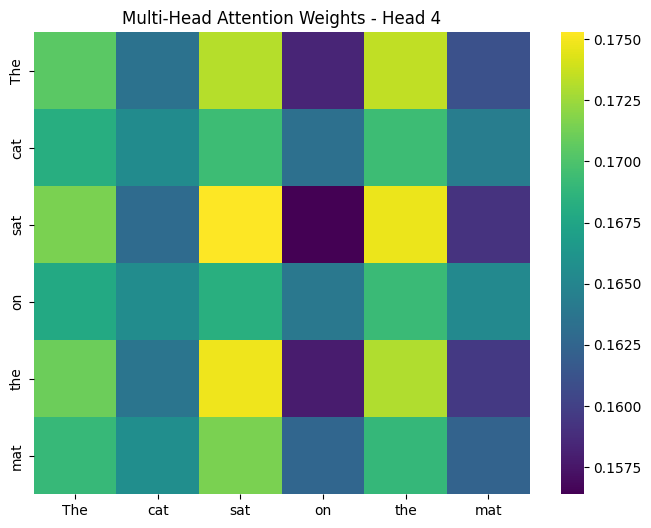

In [3]:
# --------- Part 3: Multi-Head Attention ---------
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.shape[0] if x.ndim == 3 else 1
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)

        output = self.out_proj(output)
        return weights, output

multihead_attention = MultiHeadAttention(embedding_dim, num_heads=4)
# Add batch dimension for multihead (batch=1)
multihead_weights, multihead_output = multihead_attention(embeddings.unsqueeze(0))

# Visualize each head's attention matrix individually
for i in range(multihead_attention.num_heads):
    plt.figure(figsize=(8,6))
    sns.heatmap(multihead_weights[0, i].detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Multi-Head Attention Weights - Head {i+1}")
    plt.show()

In [4]:
# --------- Part 4: Feedforward Layer ---------
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

feed_forward = FeedForward(embedding_dim, hidden_dim=16)
ff_output = feed_forward(attn_output)

print("Shape of attention output:", attn_output.shape)
print("Shape of feedforward output:", ff_output.shape)

# Optional: Print vectors for first token as example
print("\nSample token 'The' embedding vectors:")
print("Attention output vector:", attn_output[0].detach().numpy())
print("Feedforward output vector:", ff_output[0].detach().numpy())

Shape of attention output: torch.Size([6, 8])
Shape of feedforward output: torch.Size([6, 8])

Sample token 'The' embedding vectors:
Attention output vector: [-0.6803113   0.4101557  -0.09637605 -0.1400027  -0.18590613  0.3529593
  0.09783889 -0.01268673]
Feedforward output vector: [ 0.01106505  0.0568129  -0.04789606 -0.04966821 -0.00317959  0.05765279
  0.15452278 -0.10962444]


## Tasks for You:

- Run the code and observe the **attention weight heatmaps** for self-attention and different heads of multi-head attention.
- Notice how different heads pay attention to different word relationships.
- Compare the input embeddings, attention output embeddings, and feedforward output embeddings.
- Write a short summary on how the feedforward network transforms attention outputs for each token.
- Experiment by changing embedding sizes, number of heads, and hidden layer sizes.
- Reflect on why multi-head attention can capture more diverse aspects than single self-attention.
- Bonus: Implement positional encoding and add it to embeddings before attention.


## Summary

This lab will give you hands-on experience distinguishing and visualizing how:

- **Self-attention** builds relationships between words
- **Multi-head attention** extends this by capturing multiple types of relationships simultaneously
- **Feedforward networks** independently refine each token’s embedding after attention steps
